<a href="https://colab.research.google.com/github/Elshan777/CelebA-Detection/blob/master/DND_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Elshan Gadimov**  
**Neptun ID: OV7MIK** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [16]:
# ADD YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch
import os
from PIL import Image, ImageDraw,ImageOps
from torch.utils import data
from torchvision import transforms

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset
Show some images and annotations of your dataset

In [2]:
!rm -rf celeba

In [ ]:
# ADD YOUR CODE HERE
# It was mentioned that the there was an annotation problem with datasets from Kaggle, but fortunately I found the correct
# data from Kaggle 
os.environ['KAGGLE_USERNAME'] = "elshangadimov"
os.environ['KAGGLE_KEY'] = "dc78ef611b838449f7a58960e2a15014"

! kaggle datasets download -d kevinpatel04/celeba-original-wild-images
! unzip celeba-original-wild-images

In [4]:
!rm -rf celeba-original-wild-images.zip
!rm -rf 'Part 21'

In [ ]:
total_file_count = 0
for i in os.listdir():
  if i[0] == 'P':
    path = i + '/'+i
    print(path)
    print(len(os.listdir( path )))
    total_file_count += len(os.listdir( path ))
print('Total picture count', total_file_count)

There are 21 parts in data and each one has 10000 pictures in it. We will use only one part because prediction in some of our models take a really long time

#### Pre-processing the dataset

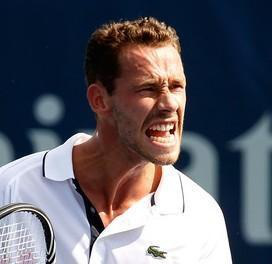

In [131]:
Image.open("/content/Part 7/Part 7/060011.jpg")

In [124]:
# ADD YOUR CODE HERE
from numpy.ma.core import resize
root = os.path.join('.', "Part 7", "Part 7")

num_samples = 2000
list_bbox = pd.read_csv(f"./list_bbox_celeba.csv")[60000:60000+num_samples] # I wrote 60000 because of the index folder Part 7
img_orig_size = (178, 218) # taken from the web page of CelebA
img_channel = 3

images = np.ones((num_samples, img_orig_size[1], img_orig_size[0], img_channel))
y = np.ones((num_samples, 4))
resize_transformer = transforms.Compose([
      transforms.Resize((218, 178))
])

sizes = []
for i in range(len(list_bbox)):
    row = list_bbox.iloc[i]
    img = Image.open(f"{root}/" + row['image_id'])
    width, height = img.size
    sizes.append([width,height])
    # img = resize_transformer(img)
    images[i] = img
    for j in range(1,5):
      if j%2 == 1:
        y[i][j-1] = int(row[j])/width*img_orig_size[0]
      else:
        y[i][j-1] = int(row[j])/height*img_orig_size[1]
print('Pre Proccess finished')

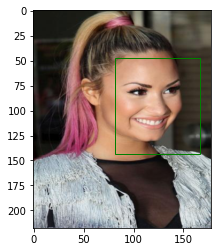

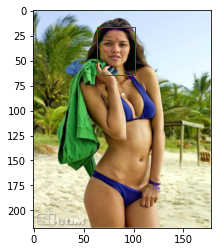

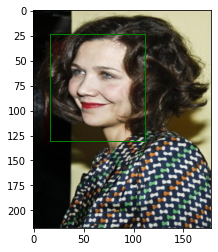

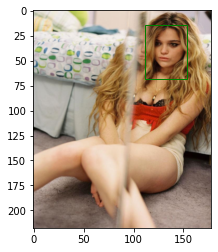

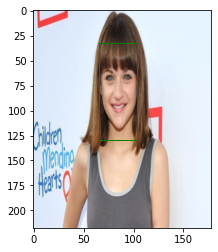

In [132]:
import matplotlib.patches as patches
import random

def show_random_images(n):

  for i in range(n):
    j = random.randint(0, num_samples)
    rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='g', facecolor='none')

    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(images[j]/255)

    # Add rectangle
    ax.add_patch(rect)

    plt.show()

show_random_images(5)

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

For the first and second pretrained models I used Facenet-Pytorch's **CASIA-Webface** and **VGGFace2**. Although they have the same architecture (Inception ResNet v1) they have different backbones 
https://github.com/timesler/facenet-pytorch
The LFW accuracy of VGGFace2 is higher than CASIA-Webface but we will test them in our dataset with our custom evaluation methods


In [133]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 26.1 MB/s 


### Question 1
Describe the main differences between the models you chose.

ADD ANSWER HERE

#### Load the models
Show the architectures

In [155]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [171]:
# ADD YOUR CODE HERE
from facenet_pytorch import MTCNN, InceptionResnetV1

mtcnn = MTCNN(image_size=(218, 178), device=device)

  0%|          | 0.00/111M [00:00<?, ?B/s]

##### Casia WebFace

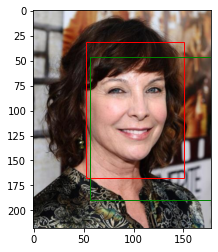

In [204]:
from PIL import Image
j = random.randint(0, num_samples) # Randomly select an image 


resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

boxes, probs = mtcnn.detect(images[j])
boxes

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2], boxes[0][3], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()

##### VGGFace2

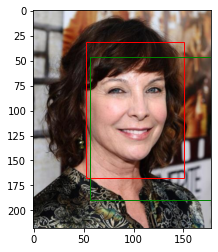

In [205]:
from PIL import Image
# j = random.randint(0, num_samples)
# j=10

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

boxes, probs = mtcnn.detect(images[j])
boxes

rect = patches.Rectangle((y[j][0], y[j][1]), y[j][2], y[j][3], linewidth=1, edgecolor='r', facecolor='none')
predicted = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2], boxes[0][3], linewidth=1, edgecolor='g', facecolor='none')

fig, ax = plt.subplots()

# Display the image
ax.imshow(images[j]/255)

# Add rectangle
ax.add_patch(rect)
ax.add_patch(predicted)

plt.show()




In [215]:
!pip install git+https://github.com/elliottzheng/face-detection.git@master

  Cloning https://github.com/elliottzheng/face-detection.git (to revision master) to /tmp/pip-req-build-9m4tgjxb
  Running command git clone -q https://github.com/elliottzheng/face-detection.git /tmp/pip-req-build-9m4tgjxb
  Created wheel for face-detection: filename=face_detection-1.0.5-py3-none-any.whl size=1638328 sha256=06d8636452b1cb9ce7c51798c03510350c00082b560855f09f23ce86b2b412b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-bbb75nj5/wheels/27/8f/8b/16350eed4526e15a515eda2f6ec106ad3a8646ade42452a993
Successfully built face-detection
  Attempting uninstall: face-detection
    Found existing installation: face-detection 0.2.2
    Uninstalling face-detection-0.2.2:
      Successfully uninstalled face-detection-0.2.2


##### RetinaFace

In [216]:
from skimage import io
from face_detection import RetinaFace

detector = RetinaFace()
all_boxes_RetinaFace = []

i = 0
for image in images:
  # print(image)
  faces = detector(image)
  try:
    box, landmarks, score = faces[0]
    all_boxes_RetinaFace.append(box)
  except:
    all_boxes_RetinaFace.append([0,0,0,0])
  if i % 500 == 0:
    print(i)
  i += 1

ImportError: ignored

## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

In [ ]:
# ADD YOUR CODE HERE

#### Show the metrics results

In [ ]:
# ADD YOUR CODE HERE

#### Show some predictions

In [ ]:
# ADD YOUR CODE HERE

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?

ADD ANSWERS HERE